# Batch criteria comparison on a simple example

In [1]:
using Pkg
Pkg.activate("..");

In [2]:
using OneClassActiveLearning, Gurobi, JuMP, SVDD
using MLKernels, MLLabelUtils, Distributions, Random

┌ Info: Precompiling OneClassActiveLearning [86a29cbe-e10f-11e8-3785-c18b489c508a]
└ @ Base loading.jl:1186
┌ Info: Precompiling Gurobi [2e9cd046-0924-5485-92f1-d5272153d98b]
└ @ Base loading.jl:1186


In [3]:
using Plots
gr(size=(600, 400))

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1186


Plots.GRBackend()

Generate random data with two normal distributions and some random outliers.

In [4]:
Random.seed!(0)
d1 = MvNormal([0.3, 0.5], 0.05)
d2 = MvNormal([0.7, 0.2], 0.03)
data1 = rand(d1, 100)
data2 = rand(d2, 25)
data_out = []
while length(data_out) < 25
    x = rand(2, 1)
    if all([pdf(dist, x) |> first for dist in [d1, d2]] .< 0.01)
        push!(data_out, x)
    end
end
data_out = hcat(data_out...)
data = hcat(data1, data2, data_out)
labels = fill(:inlier, 150)
labels[end-size(data_out, 2):end] .= :outlier
out = labels .== :outlier;

In [5]:
function Plots.plot(m::OCClassifier, ground_truth::Vector{Symbol}, prec=0, title=""; data_outliers=nothing, markersize=6, legendfontsize=12)
    r_x = range(-0.1, 1.1, length = 100)
    r_y = range(-0.1, 1.1, length = 100)
    grid = hcat([[x,y] for x in r_x for y in r_y]...)
    grid_predictions = SVDD.predict(m, grid)
    predictions = SVDD.predict(m, m.data)
    data = m.data
    grid_p = grid_predictions .- prec
    p = contourf(r_x, r_y, reshape(grid_p , length(r_x), length(r_x)), levels=range(0, maximum(grid_predictions), length=20), axis=false, legend=:bottomleft, color=:grays, markersize=markersize, legendfontsize=legendfontsize, grid=false)
    out = ground_truth .== :outlier
    scatter!(data[1, .!out], data[2, .!out], color=[:white], marker=:circle, markersize=markersize, label="Inlier")
    scatter!(data[1, out], data[2, out], color=[:red], marker=:square, markersize=markersize, label="Outlier")
    data_outliers !== nothing && scatter!(data_outliers[1, :], data_outliers[2, :], marker=:diamond, markersize=markersize, color=[:orange], label="Artificial Outlier")
    contour!(r_x, r_y, reshape(grid_p , length(r_x), length(r_x)), levels=[0], linewidth=2, seriescolor=colorant"#000000", cbar=false)
    p
end

Fit a standard SVDD model on the data.

[info | SVDD]: Adjusting Kernel Matrix.
[info | SVDD]: [ADJUST KERNEL] Maximum adjustemt of kernel matrix entry is 8.548717289613705e-15. The sum of adjustments is 2.457389229022345e-11
Academic license - for non-commercial use only
Academic license - for non-commercial use only


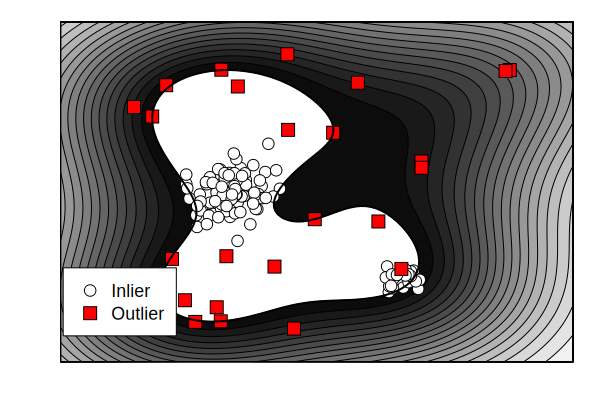

In [6]:
m = VanillaSVDD(data)
init_strategy = SVDD.SimpleCombinedStrategy(SVDD.FixedGammaStrategy(MLKernels.GaussianKernel(10)), SVDD.FixedCStrategy(0.05))
SVDD.initialize!(m, init_strategy)
SVDD.set_adjust_K!(m, true)
solver = with_optimizer(Gurobi.Optimizer; OutputFlag=0)
SVDD.fit!(m, solver)
plot(m, labels)

In [7]:
function Plots.plot(m::OCClassifier, ground_truth::Vector{Symbol}, batch::Vector{Int}, prec=0, title=""; data_outliers=nothing, linewidth=2, markersize=6, legendfontsize=12, legend=:bottomright)
    r_x = range(-0.1, 1.1, length = 100)
    r_y = range(-0.1, 1.1, length = 100)
    grid = hcat([[x,y] for x in r_x for y in r_y]...)
    grid_predictions = SVDD.predict(m, grid)
    predictions = SVDD.predict(m, m.data)
    data = m.data
    grid_p = grid_predictions .- prec
    mask = trues(size(m.data, 2))
    mask[batch] .= false
    out = ground_truth .== :outlier
    p = scatter(data[1, mask .& .!out], data[2, mask .& .!out], color=[:white], marker=:circle, markersize=markersize, label="Inlier", axis=false, legendfontsize=legendfontsize, grid=false, legend=legend)
    scatter!(data[1, mask .& out], data[2, mask .& out], color=[:gray], marker=:square, markersize=markersize * 0.7, label="Outlier")
    contour!(r_x, r_y, reshape(grid_p , length(r_x), length(r_x)), levels=[0], linewidth=linewidth, seriescolor=colorant"#000000", cbar=false)
    scatter!(data[1, batch], data[2, batch], color=[:red], marker=:diamond, markersize=markersize, label="Query")
    p
end

Compute a query batch for all three criteria:
- informativeness (closeness to the decision boundary)
- representativeness (estimated via kernel density estimation)
- diversity (minimize angle between queries in the kernel space).

In [8]:
params = Dict{Symbol, Any}(
    :k => 10,
    :SequentialStrategy => Dict{Symbol, Any}(
        :type => :DecisionBoundaryPQs,
        :param => Dict{Symbol, Any}()
    ),
    :representativeness => :KDE,
    :diversity => :AngleDiversity,
    :λ_inf => 0,
    :λ_rep => 0,
    :λ_div => 0)

function get_batch(p::Dict{Symbol, Any})
    qs = initialize_qs(IterativeBatchQs, m, data, p)
    return select_batch(qs, data, labelmap(fill(:U, size(data, 2))), collect(1:size(data, 2)))
end
b_inf = get_batch(Dict(params..., :λ_inf => 1))
b_rep = get_batch(Dict(params..., :λ_rep => 1))
b_div = get_batch(Dict(params..., :λ_div => 1))
b_plots = []
for (description, b) in [("inf", b_inf), ("rep", b_rep), ("div", b_div)]
    p = plot(m, labels, b, markersize=18, legendfontsize=20, linewidth=4, legend=false)
    savefig(p, "plots/criteria_example/criteria_example_$(description).pdf")
    push!(b_plots, plot(p, markersize=6, legendfontsize=12, linewidth=2))
end

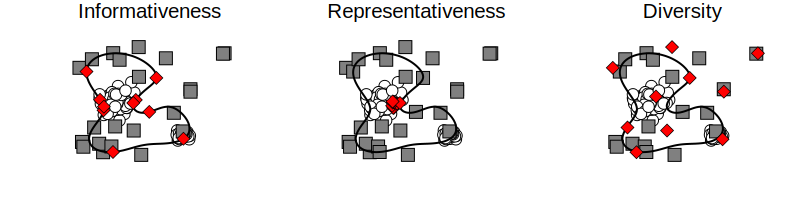

In [9]:
plot([plot(p, title=d) for (p, d) in zip(b_plots, ["Informativeness", "Representativeness", "Diversity"])]..., legend=false, size=(800, 200), layout=(1, 3))

Inliers are white circles, outliers gray boxes and the queries red diamonds.